# mammoCAD

## Introduction and Setup

With the high popularity of machien learning and broad depth of its applications, it is no surprise that the technology has been applied to medical diagnostics. However, a gap identified in cancer diagnostics AI, or Computer-Aided Diagnosis, is the lack of breast cancer CADs. Moreover, the few breast cancer CADs in current literature utilized breast histopathology, aka breast biopsies, which are an invasive diagnostic method. Mammograms are a noninvasive alternative for breast cancer diagnosis, so the development of a CAD for mammography would be beneficial.

This notebook will outline the entire workflow, from loading data to predicting outcomes, and it will demonstrate how to create a custom mammography image classification model to determine whether a mammogram reveals the existence of breast cancer.

The cell below will load the necessary packages, and make sure to enable TPU. Note that this code was run in a Kaggle kernel using TPU as the accelerator. Running the exact code in other environments may not work.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2022-08-14 01:47:17.795940: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-08-14 01:47:17.796095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-08-14 01:47:23.788976: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 01:47:23.791085: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-08-14 01:47:23.791116: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-14 01:47:23.791143: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5e3b44bc5d1d): /proc/driver/nvidia/version does not exist
2022-08-14 01:47:23.794511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


# Data

A subset of the DDSM was used for this research, found [here](https://www.kaggle.com/datasets/cheddad/miniddsm2). A subset of this dataset, specifically the JPEG dataset, was used. The data in this notebook was initially private, so the code cell below uses the Google Cloud SDK to enable TPU access to it. However, the dataset was later published [here](https://www.kaggle.com/datasets/joshuaokolo/miniddsm-jpeg-dataset).

## import data

In [2]:
# Step 1: Get the credential from the Cloud SDK
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

# Step 2: Set the credentials
user_secrets.set_tensorflow_credential(user_credential)

# Step 3: Use a familiar call to get the GCS path of the dataset
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

## set constant variables as per general better practice

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_PATH = KaggleDatasets().get_gcs_path()
IMAGE_SIZE = [512, 512]
EPOCHS = 100
print('done')

done


## load data

The data used in the notebook was only split into cancer and normal mammograms, but the dataset [I published](https://www.kaggle.com/datasets/joshuaokolo/miniddsm-jpeg-dataset) already contains train and validation splits.

In [4]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/MINI-DDSM CANCER-NORMAL DATASET/Cancer/*.jpg'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/MINI-DDSM CANCER-NORMAL DATASET/Normal/*.jpg')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print('done')

done


Run the following cell to find out how many cancerous mammography we have compared to healthy/normal mammograms.

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "Normal" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_CANCER = len([filename for filename in train_filenames if "Cancer" in filename])
print("Cancer images count in training set: " + str(COUNT_CANCER))

COUNT_NORMAL_V = len([filename for filename in val_filenames if "Normal" in filename])
print("Normal images count in testing set: " + str(COUNT_NORMAL_V))

COUNT_CANCER_V = len([filename for filename in val_filenames if "Cancer" in filename])
print("Cancer images count in testing set: " + str(COUNT_CANCER_V))

Normal images count in training set: 1916
Cancer images count in training set: 1633
Normal images count in testing set: 488
Cancer images count in testing set: 400


The dataset is fairly balanced. However, we'll still correct any imbalance later on.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'gs://kds-c3df73cc5df6db49ff0d1eec0796889af6cf91b15981a5f9d855eca6/MINI-DDSM CANCER-NORMAL DATASET/Cancer/B_3511_1.LEFT_MLO.jpg'
b'gs://kds-c3df73cc5df6db49ff0d1eec0796889af6cf91b15981a5f9d855eca6/MINI-DDSM CANCER-NORMAL DATASET/Cancer/D_4117_1.RIGHT_CC.jpg'
b'gs://kds-c3df73cc5df6db49ff0d1eec0796889af6cf91b15981a5f9d855eca6/MINI-DDSM CANCER-NORMAL DATASET/Cancer/D_4127_1.LEFT_CC.jpg'
b'gs://kds-c3df73cc5df6db49ff0d1eec0796889af6cf91b15981a5f9d855eca6/MINI-DDSM CANCER-NORMAL DATASET/Cancer/B_3067_1.LEFT_MLO.jpg'
b'gs://kds-c3df73cc5df6db49ff0d1eec0796889af6cf91b15981a5f9d855eca6/MINI-DDSM CANCER-NORMAL DATASET/Normal/D_4514_1.LEFT_CC.jpg'


2022-08-14 01:47:35.164409: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 29, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1660441655.161165064","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 29, Output num: 0","grpc_status":3}


The following cell displays how many train and test images there are. Run the cell to verify that the ratio is 80:20

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 3549
Validating images count: 888


Let's check the labels

In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/MINI-DDSM CANCER-NORMAL DATASET/*"))])
CLASS_NAMES

array(['Cancer', 'Normal'], dtype='<U6')

Our dataset currently consists of of a list of filenames. Every filename should be mapped to the relevant (image, label) pair. We can accomplish that by using the subsequent techniques.

As we only have two labels, we will rewrite the label so that `1` or `True` indicates cancer and `0` or `False` indicates normal.

In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "Cancer"
print('done')

done


The images' initial values fall between [0, 255]. We will scale this down because CNNs perform better with less data points.

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)
print('done')

done


In [11]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label
print('done')

done


In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print('done')

done


Example (image, label) pair visualization.

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (512, 512, 3)
Label:  True


Load and format the test data.

# Data Visualization

Let's first employ buffered prefetching to yield data from the disk without I/O becoming blocked.

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

print('done')

done


Call the next batch iteration of the training data.

In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

print('done')

done


Define the method to show the images in the batch.

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("CANCER")
        else:
            plt.title("NORMAL")
        plt.axis("off")
print('done')

done


Call the numpy function on the batches to return the tensor in numpy array form while the method accepts numpy arrays as inputs. Note that they appear distorted as they were resized.

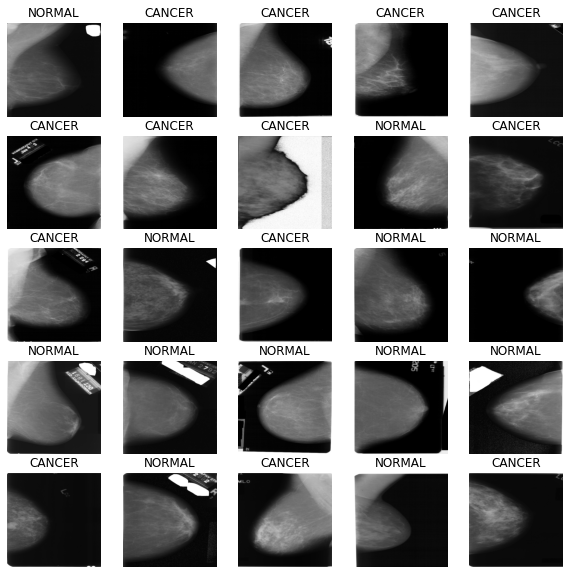

In [17]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Build the CNN

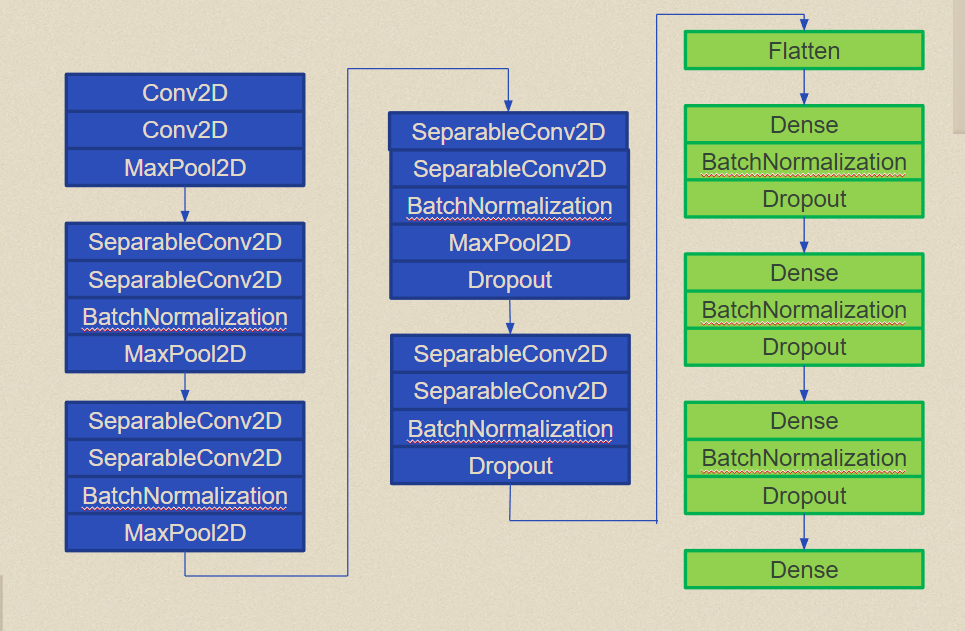

In [18]:
def build_model():
    model = tf.keras.Sequential([
        
        tf.keras.Input(shape=(512, 512, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.7),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

print('done')

done


The function that will build our model for us is defined in the next method. The Dropout layers are crucial because, as the name implies, they "drop out" specific nodes to lessen the likelihood of the model overfitting. The output of the model, which will assess whether a mammogram includes malignant tumors, should be a Dense layer with a single node.

In [19]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 256, 256, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 256, 256, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0

# Correct Data Imbalance

In [20]:
initial_bias = np.log([COUNT_CANCER/COUNT_NORMAL])
initial_bias

array([-0.15982087])

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_CANCER)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.93
Weight for class 1: 1.09


The weight for class `1` (Cancer) is slightly higher than the weight for class `0` (Normal). Because there are less normal images, each cancer image will be weighted more to balance the data as the CNN works best when the training data is balanced.

# Train the model

We will use the binary crossentropy loss because the image can only have two possible labels. Input the class weights for the model fit. The fact that we are using a TPU will make training rather quick.

Regarding metrics, precision and recall are included because they will provide a more informed picture of the model's performance. Accuracy is, of course, the fraction of the labels that are correct.

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

In [22]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=150,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
)

Epoch 1/150
27/27 [==============================] - 157s 4s/step - loss: 0.6935 - accuracy: 0.6687 - precision: 0.6225 - recall: 0.6926 - val_loss: 0.7978 - val_accuracy: 0.5521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
27/27 [==============================] - 10s 392ms/step - loss: 0.6308 - accuracy: 0.6988 - precision: 0.6597 - recall: 0.7182 - val_loss: 0.6864 - val_accuracy: 0.5586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
27/27 [==============================] - 10s 387ms/step - loss: 0.5387 - accuracy: 0.7393 - precision: 0.7048 - recall: 0.7525 - val_loss: 0.6874 - val_accuracy: 0.5599 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
27/27 [==============================] - 10s 392ms/step - loss: 0.5248 - accuracy: 0.7573 - precision: 0.7051 - recall: 0.7766 - val_loss: 0.6883 - val_accuracy: 0.5534 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/150
27/27 [==============================] - 10s 389ms/ste

# Export initial model

In [23]:
model.save('./mammoCAD_V1.h5')

# Visualize mammoCAD_V1 performance

<AxesSubplot:>

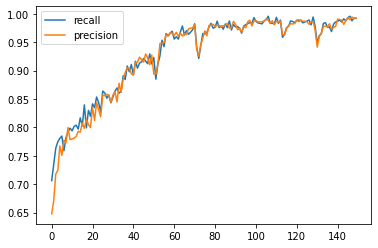

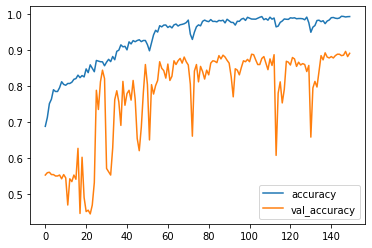

In [24]:
history_df = pd.DataFrame(history.history)
history_df[['recall', 'precision']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

Improvements can be made

# Finetune the model

We will train the model again, but with the implementation of callback functions which restore the weights of the model to the best performing ones.

In [25]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mammoCAD_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

The learning rate is also finetuned. The exponential learning rate scheduling method is shown below

In [26]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

Let's do this again

In [27]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=200,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/200
27/27 [==============================] - 24s 393ms/step - loss: 0.1359 - accuracy: 0.9554 - precision: 0.9496 - recall: 0.9532 - val_loss: 18.0165 - val_accuracy: 0.5534 - val_precision: 1.0000 - val_recall: 0.0087
Epoch 2/200
27/27 [==============================] - 11s 408ms/step - loss: 0.2975 - accuracy: 0.8744 - precision: 0.8414 - recall: 0.8991 - val_loss: 10.7708 - val_accuracy: 0.7083 - val_precision: 0.8614 - val_recall: 0.4157
Epoch 3/200
27/27 [==============================] - 11s 394ms/step - loss: 0.2223 - accuracy: 0.9077 - precision: 0.8989 - recall: 0.8995 - val_loss: 8.4682 - val_accuracy: 0.5469 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
27/27 [==============================] - 10s 378ms/step - loss: 0.1792 - accuracy: 0.9300 - precision: 0.9228 - recall: 0.9263 - val_loss: 1.6952 - val_accuracy: 0.6120 - val_precision: 0.8472 - val_recall: 0.1753
Epoch 5/200
27/27 [==============================] - 10s 385ms/step - loss: 0.1100 - a

In [28]:
model.save('./mammoCAD_V2.h5')

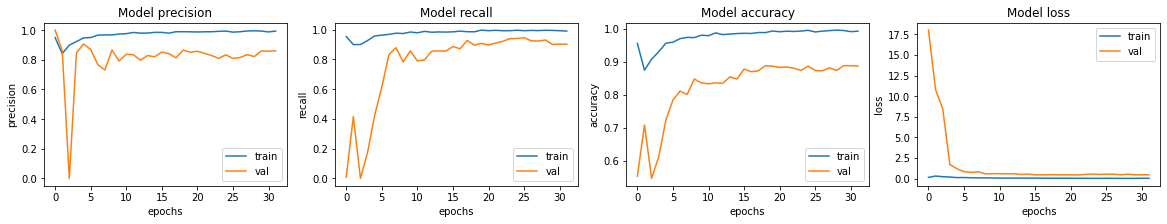

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

The initial model performed better. Let's retrain with the first method to improve the performance.

In [30]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=55,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
)

Epoch 1/55
27/27 [==============================] - 11s 388ms/step - loss: 0.0353 - accuracy: 0.9890 - precision: 0.9850 - recall: 0.9912 - val_loss: 0.4718 - val_accuracy: 0.8802 - val_precision: 0.8489 - val_recall: 0.8931
Epoch 2/55
27/27 [==============================] - 11s 410ms/step - loss: 0.0376 - accuracy: 0.9893 - precision: 0.9905 - recall: 0.9861 - val_loss: 0.4412 - val_accuracy: 0.8958 - val_precision: 0.8678 - val_recall: 0.9078
Epoch 3/55
27/27 [==============================] - 10s 382ms/step - loss: 0.0392 - accuracy: 0.9864 - precision: 0.9874 - recall: 0.9830 - val_loss: 0.4263 - val_accuracy: 0.8932 - val_precision: 0.8607 - val_recall: 0.9062
Epoch 4/55
27/27 [==============================] - 10s 384ms/step - loss: 0.0255 - accuracy: 0.9933 - precision: 0.9913 - recall: 0.9944 - val_loss: 0.3838 - val_accuracy: 0.8984 - val_precision: 0.8730 - val_recall: 0.9124
Epoch 5/55
27/27 [==============================] - 10s 390ms/step - loss: 0.0321 - accuracy: 0.9884

In [31]:
model.save('./mammoCAD_V3.h5')

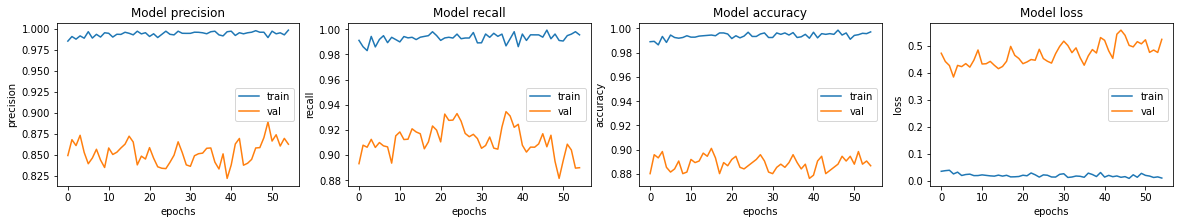

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Let's make our own callback to stop training once validation accuracy is over 90%

In [33]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 9e-1 or logs.get('val_recall') >= 9e-1:
            self.model.stop_training = True
            
callback = CustomCallback()

In [34]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=300,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    callbacks=[callback]
)

Epoch 1/300
27/27 [==============================] - 11s 389ms/step - loss: 0.0159 - accuracy: 0.9957 - precision: 0.9962 - recall: 0.9944 - val_loss: 0.5023 - val_accuracy: 0.8880 - val_precision: 0.8564 - val_recall: 0.9012


In [35]:
model.save('./mammoCAD_V4.h5')

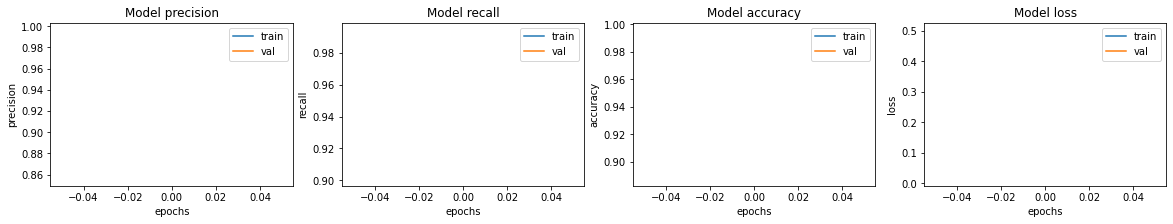

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 91e-2 or logs.get('val_recall') >= 98e-2:
            self.model.stop_training = True
            
callback = CustomCallback()

In [38]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=300,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    callbacks=[callback]
)

Epoch 1/300
27/27 [==============================] - 11s 383ms/step - loss: 0.0173 - accuracy: 0.9954 - precision: 0.9931 - recall: 0.9968 - val_loss: 0.4528 - val_accuracy: 0.8971 - val_precision: 0.8656 - val_recall: 0.9174
Epoch 2/300
27/27 [==============================] - 10s 385ms/step - loss: 0.0237 - accuracy: 0.9936 - precision: 0.9937 - recall: 0.9924 - val_loss: 0.5061 - val_accuracy: 0.8867 - val_precision: 0.8636 - val_recall: 0.8997
Epoch 3/300
27/27 [==============================] - 10s 386ms/step - loss: 0.0186 - accuracy: 0.9951 - precision: 0.9950 - recall: 0.9943 - val_loss: 0.5191 - val_accuracy: 0.8919 - val_precision: 0.8548 - val_recall: 0.9164
Epoch 4/300
27/27 [==============================] - 10s 376ms/step - loss: 0.0209 - accuracy: 0.9951 - precision: 0.9975 - recall: 0.9919 - val_loss: 0.5399 - val_accuracy: 0.8802 - val_precision: 0.8298 - val_recall: 0.9176
Epoch 5/300
27/27 [==============================] - 10s 390ms/step - loss: 0.0136 - accuracy: 0

In [39]:
model.save('./mammoCAD_V6.h5')

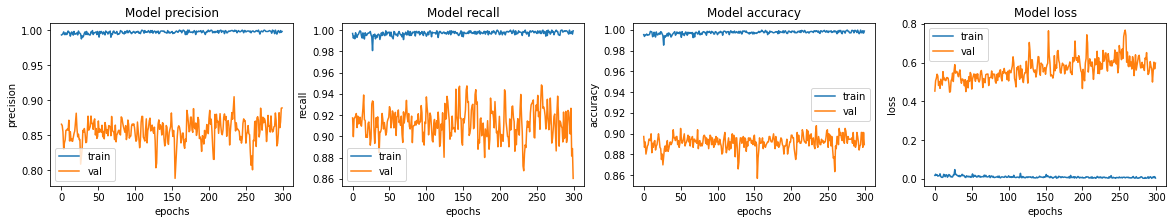

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Test the model

In [41]:
loss, acc, prec, rec = model.evaluate(test_ds)

IndexError: list index out of range

In [ ]:
#Thanks for reading my code, if you plan to include it in your work, please properly cite me
#Thanks again!
#This code was inspired by this work of Amy Jang here: https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays
#And Abhinav Sagar here:https://www.kdnuggets.com/2019/10/convolutional-neural-network-breast-cancer-classification.html